In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import folium

## Load processed data

In [2]:
nodes = pd.read_csv('ripple-asn-nodes.csv', delimiter=',', header=None, names=['asn','lat','lon']).dropna().drop_duplicates()
links = pd.read_csv('ripple-asn-links.csv', delimiter=',', header=None, names=['start','end']).dropna().drop_duplicates()

In [3]:
list_double = set()
def remove_double_asn(x):
    if(' ' in x):
        list_double.add(tuple(x.split(' ')))
        return x.split(' ')[0]
    else:
        return x

In [4]:
nodes['asn'] = nodes['asn'].apply(lambda x: remove_double_asn(x))
links['start'] = links['start'].apply(lambda x: remove_double_asn(x))
links['end'] = links['end'].apply(lambda x: remove_double_asn(x))

In [5]:
links = links[~(links['start'] == links['end'])]

#### Is there any problem to consider one AS when a node has multiple AS number?

Let's check the connectivity. If there is a link between these nodes, the node remains connected.

In [6]:
list_double

{('16509', '38895'), ('23724', '133119'), ('4808', '23724')}

('23724', '133119') and ('4808', '23724') are connected because they share a common AS

Is there any link between 16509 and 23724?

In [7]:
links[(links['start'] == '16509') & (links['end'] == '23724')]

start    end
7367   16509  23724
10894  16509  23724

Yes, so we can assume that removing one AS does not break the network

## Add latitude/longitude for each AS

In [8]:
temp = nodes[['asn','lat','lon']].set_index('asn')
temp.columns = temp.columns.get_level_values(0)

temp['pos'] = list(zip(temp.lat, temp.lon))

ases = temp['pos'].to_dict()

## Create graph

In [9]:
topo = nx.Graph()
edges = [tuple(x) for x in links.values]

In [10]:
topo.add_nodes_from(ases)
topo.add_edges_from(edges)

## Plot graph

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


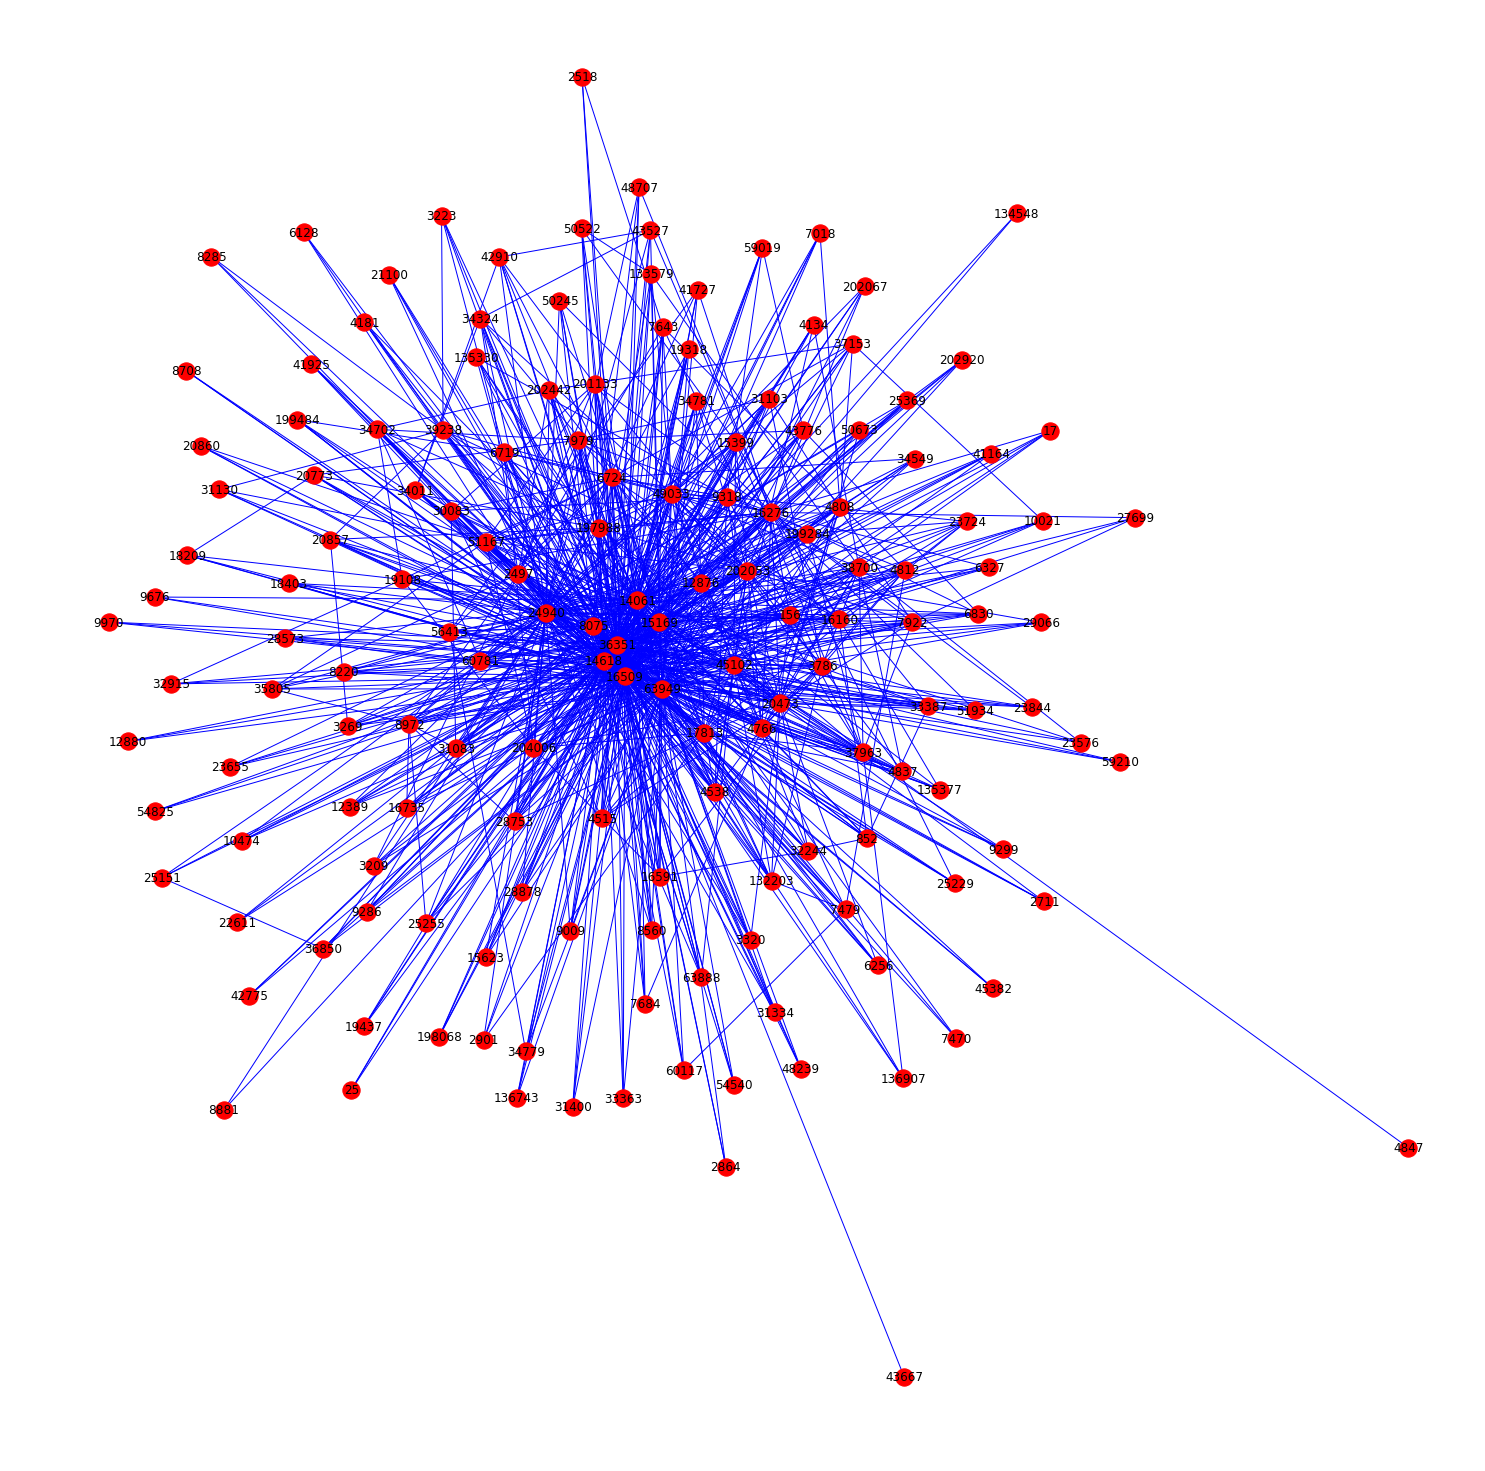

In [11]:
plt.figure(figsize=(20,20))
nx.draw(topo, with_labels = True, font_color='black', edge_color='blue')

## Plot graph on map

In [12]:
def generate_map(ases,edges):
    edges_position = set()
    for elem in edges:
        lat = ases[elem[0]]
        lon = ases[elem[1]]
        edges_position.add((lat,lon))
        
    # Make an empty map
    m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

    # I can add marker one by one on the map
    for elem in ases.keys():
        folium.Marker(ases[elem], popup=elem).add_to(m)

    for elem in edges_position:
        folium.PolyLine(locations = elem, weight=1).add_to(m) 
    return m

In [13]:
generate_map(ases,edges)

## Explore shortest path algorithm of NetworkX

## Compute shortest path for each tuple (source,target) and create Graph

In [14]:
shortest_graph = nx.Graph()
shortest_graph.add_nodes_from(ases)

In [15]:
max_path = -1
shortest_edges = set()
for source_targets in nx.all_pairs_shortest_path(topo, cutoff=10):
    source = source_targets[0]
    for target in source_targets[1].keys():
        route = source_targets[1][target]
        max_path = max(max_path,len(route))
        if (len(route) >= 2):
            for n in range(len(route)-1):
                s = route[n]
                t = route[n+1]
                if not (tuple([s,t]) in shortest_edges or tuple([t,s]) in shortest_edges):
                    shortest_edges.add(tuple([route[n], route[n+1]]))
                    
shortest_graph.add_edges_from(shortest_edges)
print('Longest path is {}'.format(max_path))

Longest path is 4


## Plot Graph

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


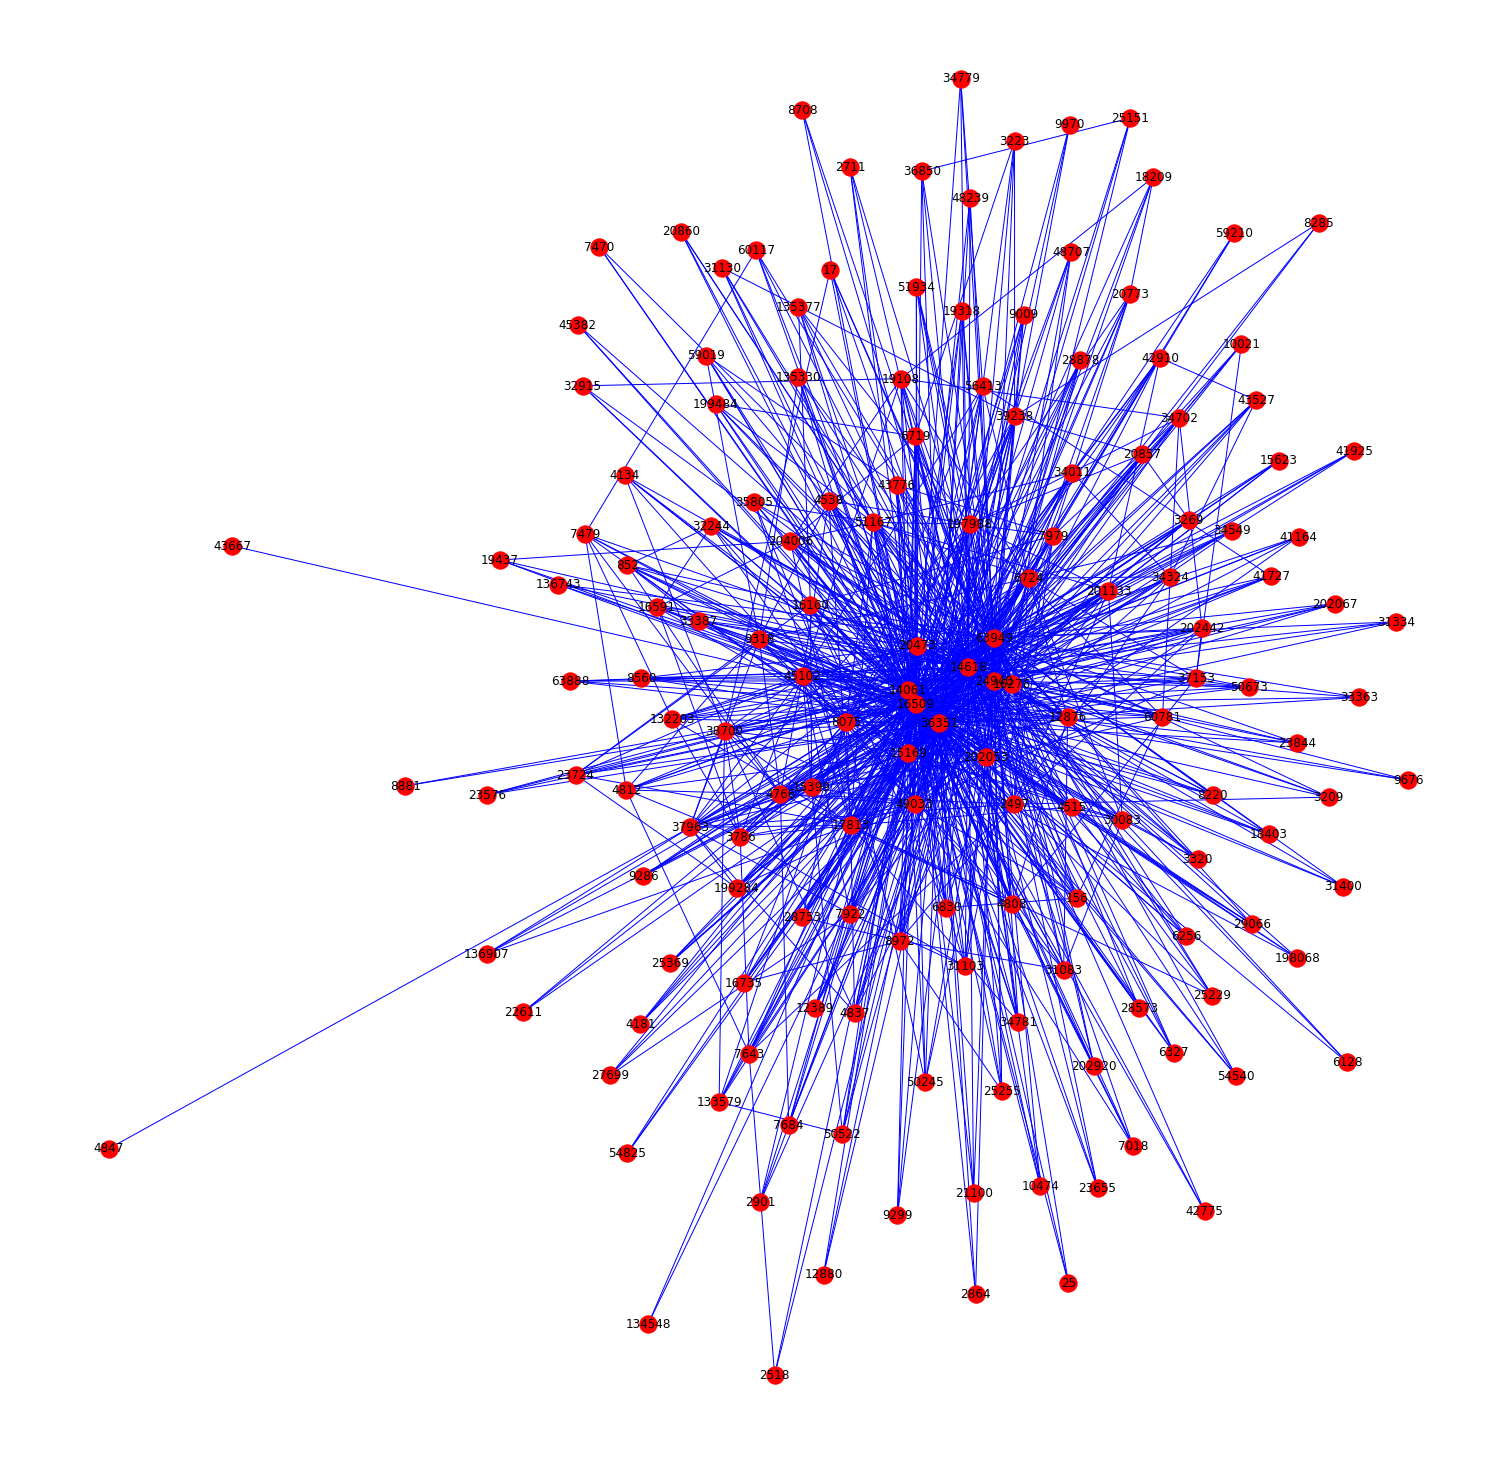

In [16]:
plt.figure(figsize=(20,20))
nx.draw(shortest_graph, with_labels = True, font_color='black', edge_color='blue')

## Plot graph on Map

In [17]:
generate_map(ases,shortest_edges)

Well, there is not so much difference. Do shortest paths function removes many edges?

In [18]:
print('Edges removed : {}'.format(len(edges)-len(shortest_edges)))

Edges removed : 241


## Compute shortest path following the paper 

http://www.cs.yale.edu/homes/schapira/BGPAttack.pdf

## Compute method to select best path (shortest + smallest ASN)

In [19]:
def column(matrix, i):
    return np.array([row[i] for row in matrix]).astype(int)

In [20]:
def select_best(paths):
    nb_col = len(paths[0])
    for c in range(nb_col):
        col = column(paths,c)
        min_indices = np.where(col == col.min())[0]
        paths = [paths[i] for i in min_indices]
    assert(len(paths) == 1)
    return paths[0]

In [21]:
best_paths = []
for source in ases.keys():
    for target in ases.keys():
        if source != target:
            paths = np.array(list(nx.all_shortest_paths(topo,source,target)))
            if(len(paths) != 1):
                best_path = select_best(paths)
                best_paths.append(best_path)
            else:
                best_paths.append(paths[0])
len(best_paths)

24492

## Convert paths to edges

In [22]:
best_edges = set()
for route in best_paths:
    if (len(route) >= 2):
        for n in range(len(route)-1):
            s = route[n]
            t = route[n+1]
            if not (tuple([s,t]) in best_edges or tuple([t,s]) in best_edges):
                best_edges.add(tuple([route[n], route[n+1]]))

print('Edges removed : {}'.format(len(edges)-len(best_edges)))

Edges removed : 241


## Create Graph and plot it

In [23]:
best_graph = nx.Graph()
best_graph.add_nodes_from(ases)
best_graph.add_edges_from(best_edges)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


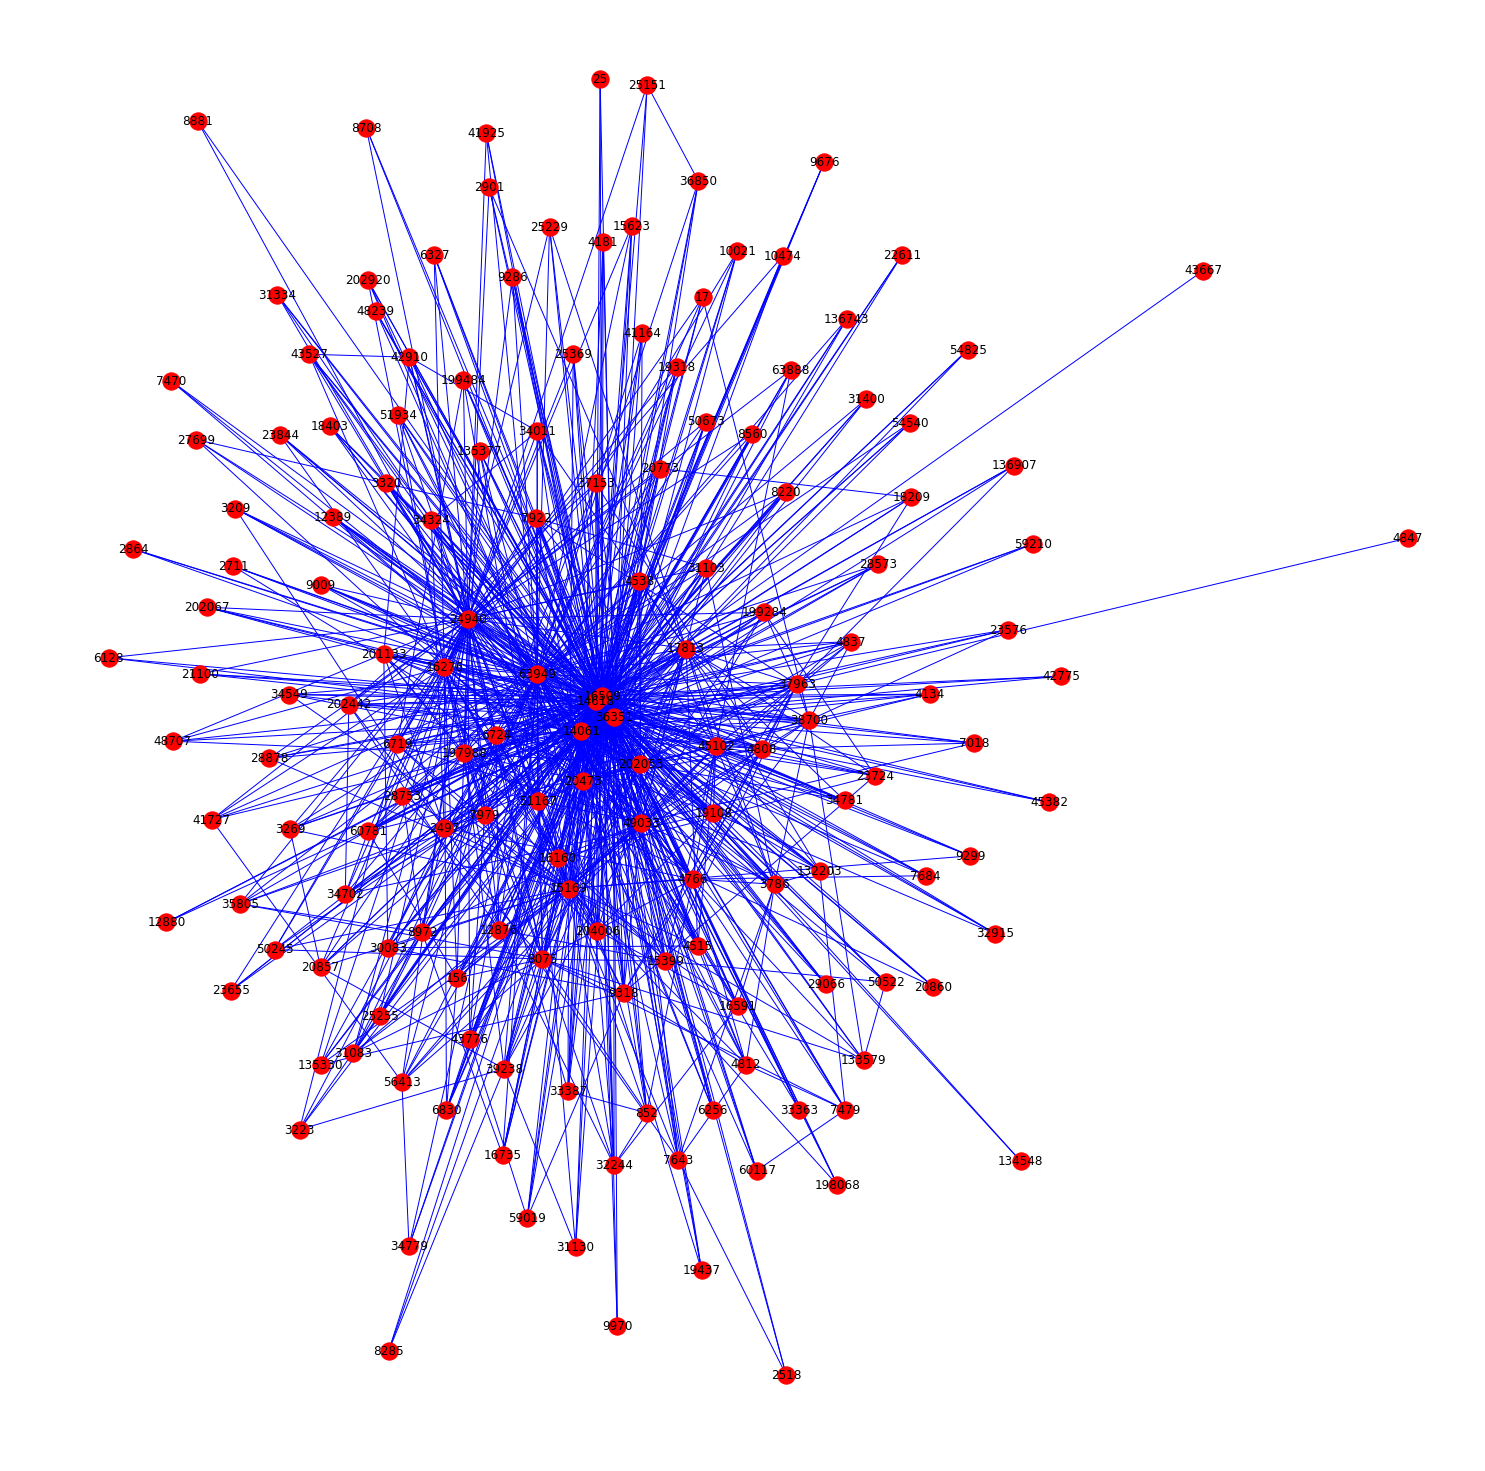

In [24]:
plt.figure(figsize=(20,20))
nx.draw(shortest_graph, with_labels = True, font_color='black', edge_color='blue')

In [25]:
generate_map(ases,best_edges)

## Analyze connectivity

Display how many nodes must be removed to disconnect the graph

In [26]:
nx.node_connectivity(best_graph)

1

I assume the most connected one can break the network

In [27]:
links.groupby('start').size().sort_values(ascending=False).index[0]

'16509'

In [28]:
links.groupby('end').size().sort_values(ascending=False).index[0]

'16509'

In [29]:
best_graph.remove_node('16509')

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


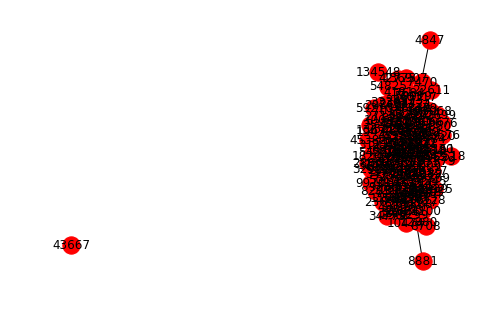

In [30]:
nx.draw(best_graph,with_labels=True)

If 16509 stop responding, 43667 is completly disconnected

Who is 16509? 
Country:  US
Registration Date:  2000-05-04
Registrar:  arin
Owner:  AMAZON-02 - Amazon.com, Inc., US

Who is 43667?
Country:  RU
Registration Date:  2007-09-10
Registrar:  ripencc
Owner:  VRMNT-AS, RU

